In [24]:
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = [20, 10]

np.random.seed(7)

N_SECTIONS = 100

In [25]:
N, M = 300, 300
PROBABILITY = 0.997
mat = np.random.rand(N, M) >= PROBABILITY

In [26]:
def read_mtx(file, boolean=True):
    with open(file) as f:
        s = f.readline()
        symmetric = True if s.startswith("%%MatrixMarket") and "symmetric" in s else False

        while s.startswith("%"):
            s = f.readline()
        N, M, _ = map(int, s.split())

        mat = np.zeros((N, M), dtype=bool) if boolean else np.zeros((N, M), dtype=float)

        for line in f:
            i, j = map(int, line.split()[:2])
            value = 1 if boolean else float(line.split()[2])
            
            mat[i - 1, j - 1] = value
            if symmetric:
                mat[j - 1, i - 1] = value
    return mat, N, M

In [27]:
mat_paths = {
    "first": "../matrices/first/C_sparsity.mtx",
    "cell1": "../matrices/cell1/C_sparsity.mtx",
    "jan99jac060sc": "../matrices/jan99jac060sc/C_sparsity.mtx",
    "c-22": "../../tests/c-22.mtx",
    "1138_bus": "../../tests/1138_bus.mtx",
    "viscoplastic2": "../../tests/viscoplastic2.mtx",
    "n3c4": "../matrices/n3c4/C_sparsity.mtx",
    "tina": "../matrices/tina/C_sparsity.mtx",
}

mat, N, M = read_mtx(mat_paths["jan99jac060sc"], boolean=True)

In [28]:
mat = mat.astype(bool)

In [29]:
SEC_SIZE = N // N_SECTIONS

In [30]:
def print_mat(mat):
    for i in range(N):
        if i % SEC_SIZE == 0:
            print("-" * ((M + N_SECTIONS) * 2 + 1))
        for j in range(M):
            if j % SEC_SIZE == 0:
                print("|", end=" ")
            print(f"{mat[i][j]}", end=" ") if mat[i][j] != 0 else print(" ", end=" ")
        print("|")
    print("-" * ((M + N_SECTIONS) * 2 + 1))
    print()

def show_mat(mat, show=False):
    if mat.shape[0] < 1000 or show == True:
        plt.figure()
        plt.imshow(mat, cmap="binary")

In [31]:
print("Non-zeros: ", np.sum(mat))
print(f"Non-zeros ratio: {np.sum(mat) / (N * M) * 100:.2f}%")

Non-zeros:  564131
Non-zeros ratio: 0.13%


In [32]:
def get_sections(mat):
    return (np.add.reduceat(np.add.reduceat(mat, np.arange(0, N, SEC_SIZE), axis=0),
                        np.arange(0, M, SEC_SIZE), axis=1) > 0).astype(bool)

def iteration(mat, i, shuffled_rows=None, shuffled_cols=None):
    transpose = i % 2 != 0
    mat = mat.T if transpose else mat

    indices = [np.nonzero(row)[0] for row in mat]
    indices = [x if len(x) > 0 else [N if transpose else M] for x in indices]
    shuffling = np.argsort([np.mean(x) for x in indices])
    sorted_mat = mat[shuffling]
    
    sorted_mat = sorted_mat.T if i % 2 != 0 else sorted_mat

    if not (shuffled_rows.any() == None and shuffled_cols.any() == None):
        if transpose:
            shuffled_cols = shuffled_cols[shuffling]
        else:
            shuffled_rows = shuffled_rows[shuffling]
        
    sorted_sec_indices = get_sections(sorted_mat)
    return sorted_mat, sorted_sec_indices, shuffled_rows, shuffled_cols

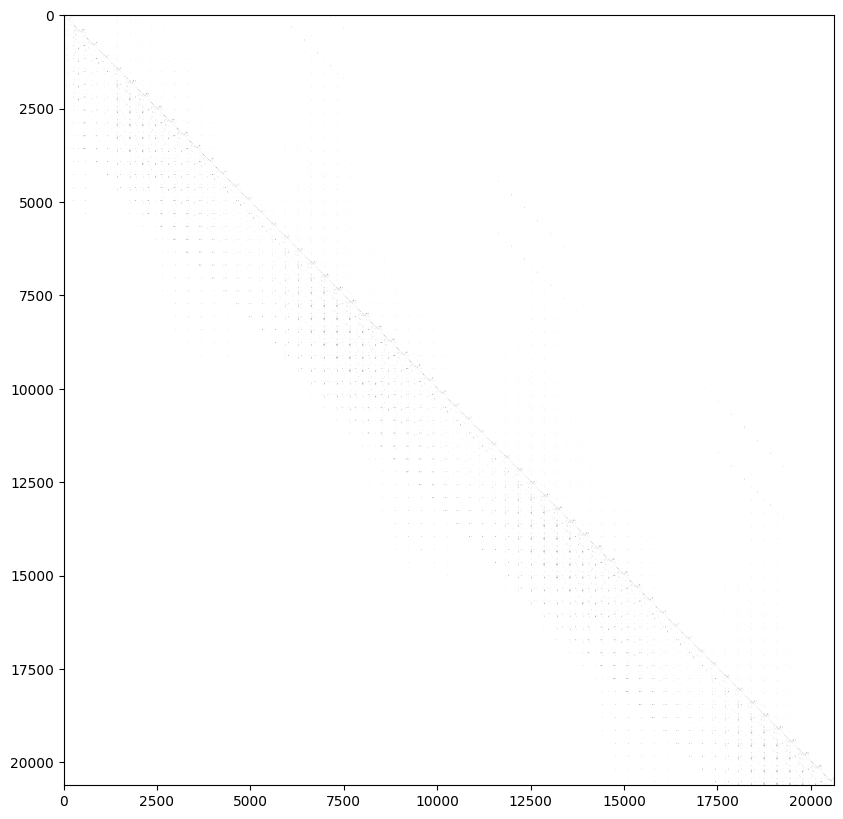

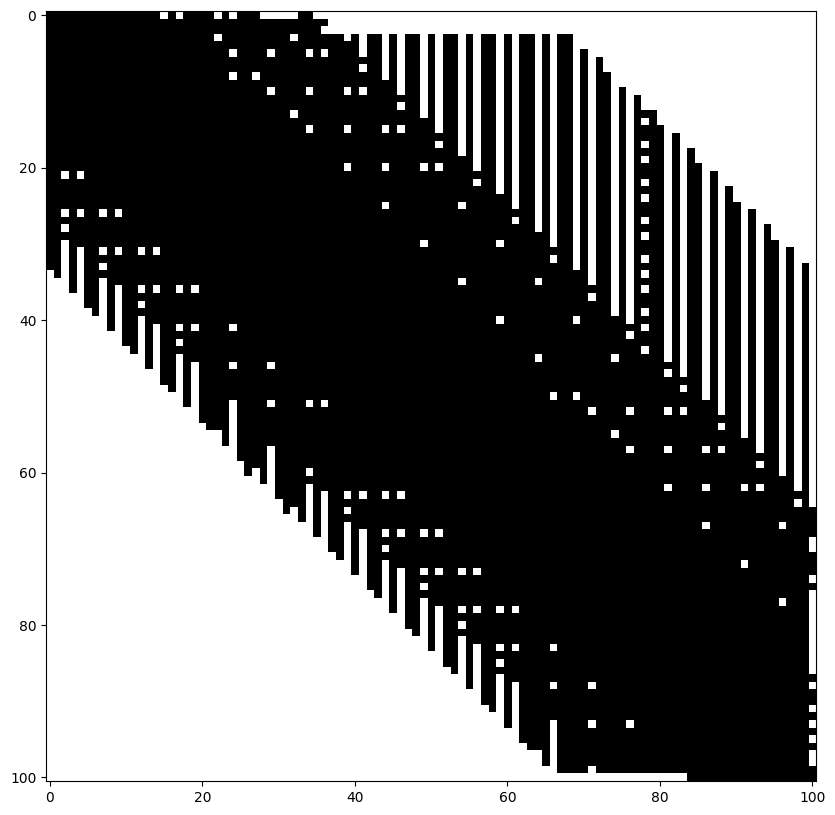

In [33]:
show_mat(mat, show=True)

sec_indices = get_sections(mat)
show_mat(sec_indices)

In [34]:
sorted_mat = mat
shuffled_rows = np.arange(N)
shuffled_cols = np.arange(M)

fig = plt.figure()
frames = []
frames.append([plt.imshow(sec_indices, cmap="binary", animated=True)])
for i in tqdm(range(100)):
    sorted_mat, sorted_sec_indices, shuffled_rows, shuffled_cols = \
        iteration(sorted_mat, i, shuffled_rows=shuffled_rows, shuffled_cols=shuffled_cols)
    frames.append([plt.imshow(sorted_sec_indices, cmap="binary", animated=True)])
plt.close()

100%|██████████| 100/100 [07:57<00:00,  4.78s/it]


In [35]:
ani = animation.ArtistAnimation(fig, frames, interval=300, blit=True, repeat_delay=1000)
ani.save('tmp.mp4')

In [36]:
print("Non-zeros in sec_indices: ", np.sum(sec_indices))
print(f"Non-zeros ratio in sec_indices: {np.sum(sec_indices) / (N // SEC_SIZE * M // SEC_SIZE) * 100:.2f}%")

print("Non-zeros in sorted_sec_indices: ", np.sum(sorted_sec_indices))
print(f"Non-zeros ratio in sorted_sec_indices: {np.sum(sorted_sec_indices) / (N // SEC_SIZE * M // SEC_SIZE) * 100:.2f}%")

Non-zeros in sec_indices:  6316
Non-zeros ratio in sec_indices: 63.12%
Non-zeros in sorted_sec_indices:  4196
Non-zeros ratio in sorted_sec_indices: 41.93%


In [37]:
def check_correctness(mat, name):
    mat, N, M = read_mtx(f"../matrices/{name}/C_sparsity.mtx", boolean=True)
    SEC_SIZE = 1

    shuffled_rows = np.arange(N)
    shuffled_cols = np.arange(M)

    sorted_mat = mat
    for i in tqdm(range(10)):
        sorted_mat, sec_indices, shuffled_rows, shuffled_cols = iteration(sorted_mat, i, shuffled_rows=shuffled_rows, shuffled_cols=shuffled_cols)

    print(shuffled_rows)
    print(shuffled_cols)

    A, _, _ = read_mtx(f"../matrices/{name}/A.mtx", boolean=False)
    B, _, _ = read_mtx(f"../matrices/{name}/B.mtx", boolean=False)
    C = A.dot(B)

    C_real, _, _ = read_mtx(f"../matrices/{name}/C_expected.mtx", boolean=False)

    A = A[shuffled_rows]
    B = B[:, shuffled_cols]
    C_shuffled = A.dot(B)

    C_shuffled = C_shuffled[shuffled_rows]
    C_shuffled = C_shuffled[:, shuffled_cols]

    print(np.sum(C_real - C_shuffled))
    print(np.sum(C - C_shuffled))

    return sorted_mat

mat, N, M = read_mtx("../matrices/first/C_sparsity.mtx", boolean=True)
sorted_mat = check_correctness(mat, "first")

100%|██████████| 10/10 [00:00<00:00, 1910.58it/s]

[  9  93  10   3   7   6  33  11   4  55  60 115  82  49  38  27 126  24
  34 104  44  35  77  45  36  37  16  28  17  29  57  31  47  56  40  42
  39  22  15  99  43  48  54  18  20  26  46  32  50  68  21 148  71  51
  88  89  53  58  80  83  87  59  79  81 155  86  67 127 133  61  64  84
  78 156  66 128 124  65 134 125 159 161  69  91 100  76  72 132  70 122
 101 123  75 137 103 144 102 121 131  62 113  73 154 143  74  90 138  97
 163 112  92 158 160 157  94 105  95 106 130 114  98 164 135 136 116  85
 108 117 145 118 119 141 150 139 109 146  63 129 147 142 152 149 153 120
 162 107  96  41 151 140  52   5  19  12  13   2   8  14  23  25  30 110
 111   1   0]
[ 16  60  38  49   5  82  27   1  93   3   4   6   7   2   0  10 104   9
  22  11  33  14  47  44  50  13  35 126 130  39  36  12  46  40  34  48
  45  43  74  20  42 115  17  71 122 123  21 128  15  37  18 119  25  66
  23 125  51  24  57  26 124  56  54  58  69  53  80  64 158  28  59 157
 156  55  84  97 155  91 127  29  61 